In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        pass
        #print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Define directories 

In [15]:
root_dir = '../input/intel-image-classification/'
train_dir = root_dir + 'seg_train/seg_train/'
val_dir = root_dir + 'seg_test/seg_test/'

In [11]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [12]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [16]:
classes = os.listdir(train_dir)
print("Classes : ", classes)

Classes :  ['street', 'forest', 'mountain', 'buildings', 'glacier', 'sea']


## Data Augmentation using Keras ImageDataGenerator

In [17]:
batch_size = 64
IMG_HEIGHT = 150
IMG_WIDTH = 150

train_image_generator = ImageDataGenerator( rescale=1./255,
                                            horizontal_flip=True
)

val_image_generator = ImageDataGenerator( rescale=1./255)

    
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                       directory=train_dir,
                                                       shuffle=True,
                                                       target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                       class_mode='categorical')

val_data_gen = val_image_generator.flow_from_directory(batch_size=batch_size,
                                                       directory=val_dir,
                                                       shuffle=True,
                                                       target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                       class_mode='categorical')

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


In [18]:
total_train=len(train_data_gen)
total_val=len(val_data_gen)

print("Total training data batches : ", total_train)
print("Total validation data batches: ", total_val)

Total training data batches :  220
Total validation data batches:  47


## Plot sample images

In [23]:
def plotImages(img_arr):
    
    fig, axes = plt.subplots(1, 4, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( img_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [24]:
training_images, _ = next(train_data_gen)

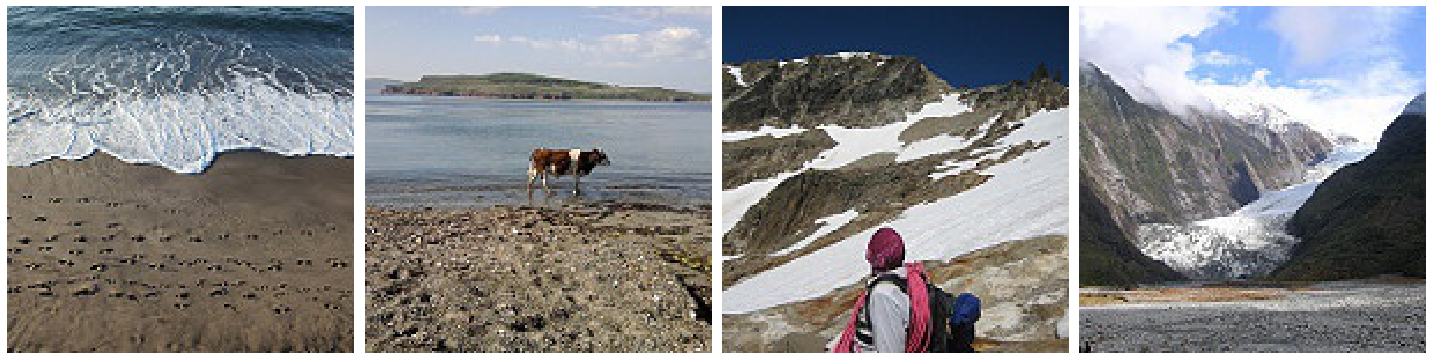

In [26]:
plotImages(training_images[:4])

## Transfer Learning using VGG19 - Base model

In [29]:
# Define input tensor shape, in our case it will be 150x150x3 
input_tensor = tf.keras.layers.Input(shape=(150, 150, 3))
                                            
# Load base model as VGG19 
base_model = tf.keras.applications.vgg19.VGG19(input_tensor=input_tensor, weights='imagenet', include_top=False)

80142336/80134624 [==============================] - 3s 0us/step


In [31]:
print("Total number of layers in base model : ",len(base_model.layers))

Total number of layers in base model :  22


In [32]:
## Let's freeze training for 15 layers and use the rest top with trainable weights

for layer in base_model.layers[:15]:
    layer.trainable = False
for layer in base_model.layers[15:]:
    layer.trainable = True

## Define classification model

In [34]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
x = Dense(64, activation='relu')(x)
predictions = Dense(6, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

In [35]:
opt = tf.keras.optimizers.Nadam(learning_rate=0.00001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [36]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [37]:
epochs = 10

history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=total_train,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val
)

Train for 220 steps, validate for 47 steps
Epoch 1/10
220/220 [==============================] - 73s 333ms/step - loss: 0.6176 - accuracy: 0.7743 - val_loss: 0.3417 - val_accuracy: 0.8787
Epoch 2/10
220/220 [==============================] - 44s 202ms/step - loss: 0.3032 - accuracy: 0.8933 - val_loss: 0.2793 - val_accuracy: 0.8990
Epoch 3/10
220/220 [==============================] - 43s 195ms/step - loss: 0.2533 - accuracy: 0.9120 - val_loss: 0.3195 - val_accuracy: 0.8803
Epoch 4/10
220/220 [==============================] - 44s 198ms/step - loss: 0.2239 - accuracy: 0.9212 - val_loss: 0.2615 - val_accuracy: 0.9040
Epoch 5/10
220/220 [==============================] - 44s 198ms/step - loss: 0.1963 - accuracy: 0.9316 - val_loss: 0.2653 - val_accuracy: 0.9057
Epoch 6/10
220/220 [==============================] - 44s 200ms/step - loss: 0.1790 - accuracy: 0.9377 - val_loss: 0.2333 - val_accuracy: 0.9170
Epoch 7/10
220/220 [==============================] - 43s 196ms/step - loss: 0.1571 - a

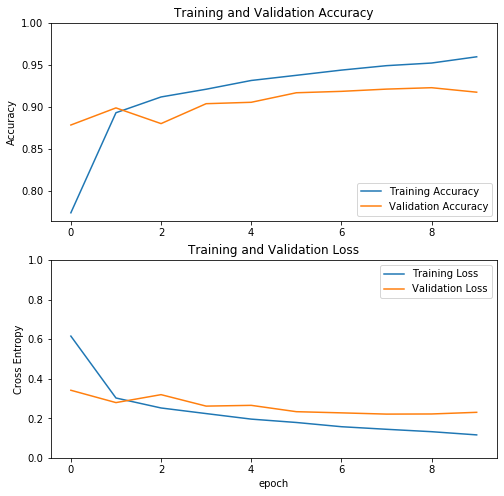

In [38]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()